## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Identify drugs that has been approved or in-clinical-trial or in-test-for ovarian cancer


In [46]:
from TCT import name_resolver
from TCT import node_normalizer
from TCT import translator_metakg
from TCT import translator_kpinfo
from TCT import TCT

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import pandas as pd
import  seaborn as sns
import networkx as nx
import numpy as np
import ipycytoscape
import yaml

In [35]:
# Preparation 
# Step1: List all the APIs in the translator system
Translator_KP_info,APInames= translator_kpinfo.get_translator_kp_info()
print(len(Translator_KP_info))
# Step 2: Get metaKG and all predicates from Translator APIs through the SmartAPI system
metaKG = translator_metakg.get_KP_metadata(APInames) 
print(metaKG.shape)
# Add metaKG from Plover API based KG resources
APInames,metaKG = translator_metakg.add_plover_API(APInames, metaKG)
print(metaKG.shape)
# Step 3: list metaKG information
All_predicates = list(set(metaKG['Predicate']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
API_withMetaKG = list(set(metaKG['API']))
print(len(API_withMetaKG))
print(len(All_predicates))
print(len(All_categories))

# ARA list
API_withMetaKG = set(metaKG['API'])
print("ARA list:", set(APInames.keys()) - API_withMetaKG)
# find the KG in one individual API (optional)
#metaKG.loc[metaKG['API'] == 'CATRAX Pharmacogenomics KP - TRAPI 1.5.0',['API','Predicate','Subject','Object']].drop_duplicates()

53
(10580, 5)
(22129, 5)
42
184
108
ARA list: {'mediKanren', 'OpenPredict API', 'Sri-node-normalizer(Trapi v1.5.0)', 'Autonomous Relay System (ARS) TRAPI', 'Answer-coalesce(Trapi v1.5.0)', 'Workflow-runner(Trapi v1.5.0)', 'Cqs(Trapi v1.5.0)', 'ARAX Translator Reasoner - TRAPI 1.5.0', 'Aragorn(Trapi v1.5.0)', 'Sri-answer-appraiser(Trapi v1.5.0)'}


In [36]:
# Find everything that is connected to a specific node

In [37]:
input_node1 = 'Ovarian cancer'
input_node1_info = name_resolver.lookup(input_node1)
input_node1_id = input_node1_info.curie
print("Input node ID:", input_node1_id)
input_node1_list = [input_node1_info.curie]  
input_node1_category =  list(input_node1_info.types)
print("suggesed category for the input node:" )
print(input_node1_category)
print("User defined category:")
input_node1_category = ['biolink:Disease', 'biolink:DiseaseOrPhenotypicFeature']
print(input_node1_category)

Input node ID: MONDO:0008170
suggesed category for the input node:
['biolink:Disease', 'biolink:DiseaseOrPhenotypicFeature', 'biolink:BiologicalEntity', 'biolink:ThingWithTaxon', 'biolink:NamedThing', 'biolink:Entity']
User defined category:
['biolink:Disease', 'biolink:DiseaseOrPhenotypicFeature']


In [38]:
input_node2_list = []
input_node2_category = ['biolink:SmallMolecule', 'biolink:Drug', 'biolink:ChemicalEntity']


In [39]:
# Automatically select predicates and APIs based on the input node categories
sele_predicates, sele_APIs, API_URLs = TCT.sele_predicates_API(input_node1_category,
                                                           input_node2_category,
                                                           metaKG, APInames)
print("Selected predicates:", sele_predicates)
print("\n")
print("Selected APIs:", sele_APIs)


Selected predicates: ['biolink:occurs_together_in_literature_with', 'biolink:is_diagnosed_by', 'biolink:has_biomarker', 'biolink:caused_by', 'biolink:interacts_with', 'biolink:condition_predisposed_by', 'biolink:tested_by_clinical_trials_of', 'biolink:correlated_with', 'biolink:treated_by', 'biolink:disrupts', 'biolink:applied_to_treat', 'biolink:subclass_of', 'biolink:exacerbates_condition', 'biolink:has_contraindication', 'biolink:location_of', 'biolink:produces', 'biolink:regulates', 'biolink:has_real_world_evidence_of_association_with', 'biolink:target_for', 'biolink:derives_from', 'biolink:produced_by', 'biolink:ameliorates_condition', 'biolink:drug_regulatory_status_world_wide', 'biolink:contributes_to', 'biolink:tested_by_preclinical_trials_of', 'biolink:treats_or_applied_or_studied_to_treat', 'biolink:manifestation_of', 'biolink:condition_exacerbated_by', 'biolink:physically_interacts_with', 'biolink:contribution_from', 'biolink:adverse_event_of', 'biolink:gene_associated_with_

In [40]:
# Manually select predicates and APIs based on the input node categories
sele_predicates = ['biolink:treats', 'biolink:in_clinical_trials_for']
sele_APIs = ['Automat-drug-central(Trapi v1.5.0)', 'Clinical Trials KP - TRAPI 1.5.0','Drug Approvals KP - TRAPI 1.5.0']
API_URLs = [APInames[api] for api in sele_APIs if api in APInames]

In [41]:
# Step 4: Format query json
# not consider the category of input_node 1
query_json1 = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   [],  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
# specify the category of input_node1
query_json2 = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates

In [42]:

# Step 5: Query Translator APIs and parse results
result1 = TCT.parallel_api_query(API_URLs,query_json=query_json1, max_workers=len(API_URLs))
#result2 = TCT.parallel_api_query(API_URLs,query_json=query_json2, max_workers=len(API_URLs))
#result = result1 | result2
result = result1

Success!https://multiomics.rtx.ai:9990/dakp/query
Success!https://automat.transltr.io/drugcentral/query/
Success!https://multiomics.rtx.ai:9990/ctkp/query


In [43]:
# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


NodeNorm does not know about these identifiers: UNII:8617Z5FMF6,UNII:RP9RQ0SOM8,UNII:HT3R7C012Q,UNII:BPG11IF0HW,UNII:YR3G369F5A,UNII:IZR558KO53,UNII:NP6CFH3G8H,UNII:4XTQ10247Y,UNII:Y8DGL9885E,UNII:JDS6958QAG,UNII:W2ZU1RY8B0,UNII:RXG7T6RB8K,UNII:17K7SN702N,UNII:S4MK9TOL0D


NodeNorm does not know about these identifiers: UNII:JDS6958QAG,UNII:Y8DGL9885E,UNII:4XTQ10247Y,UNII:S4MK9TOL0D,UNII:W2ZU1RY8B0,UNII:RXG7T6RB8K,UNII:17K7SN702N,UNII:RP9RQ0SOM8,UNII:BPG11IF0HW,UNII:HT3R7C012Q,UNII:8617Z5FMF6,UNII:NP6CFH3G8H,UNII:IZR558KO53,UNII:YR3G369F5A
[Text(0.5, 0, 'Niraparib'), Text(2.5, 0, 'Topotecan'), Text(4.5, 0, 'Olaparib'), Text(6.5, 0, 'Melphalan'), Text(8.5, 0, 'Cisplatin'), Text(10.5, 0, 'Bevacizumab'), Text(12.5, 0, 'Busulfan'), Text(14.5, 0, 'DUOCARMAZINE'), Text(16.5, 0, 'Anastrozole'), Text(18.5, 0, 'TETANUS TOXOID HELPER PEPTIDE'), Text(20.5, 0, 'Neratinib'), Text(22.5, 0, 'AZD4547'), Text(24.5, 0, 'Tinostamustine'), Text(26.5, 0, 'Fenretinide'), Text(28.5, 0, 'Sunitinib'), Text(30.5, 0, 'Pimasertib'), Text(32.5, 0, 'Toremifene'), Text(34.5, 0, 'Bortezomib'), Text(36.5, 0, 'motesanib diphosphate'), Text(38.5, 0, 'Interferon gamma-1b'), Text(40.5, 0, 'Dostarlimab'), Text(42.5, 0, 'FOLLICLE-STIMULATING HORMONE RECEPTOR'), Text(44.5, 0, 'Cabozantinib'), 

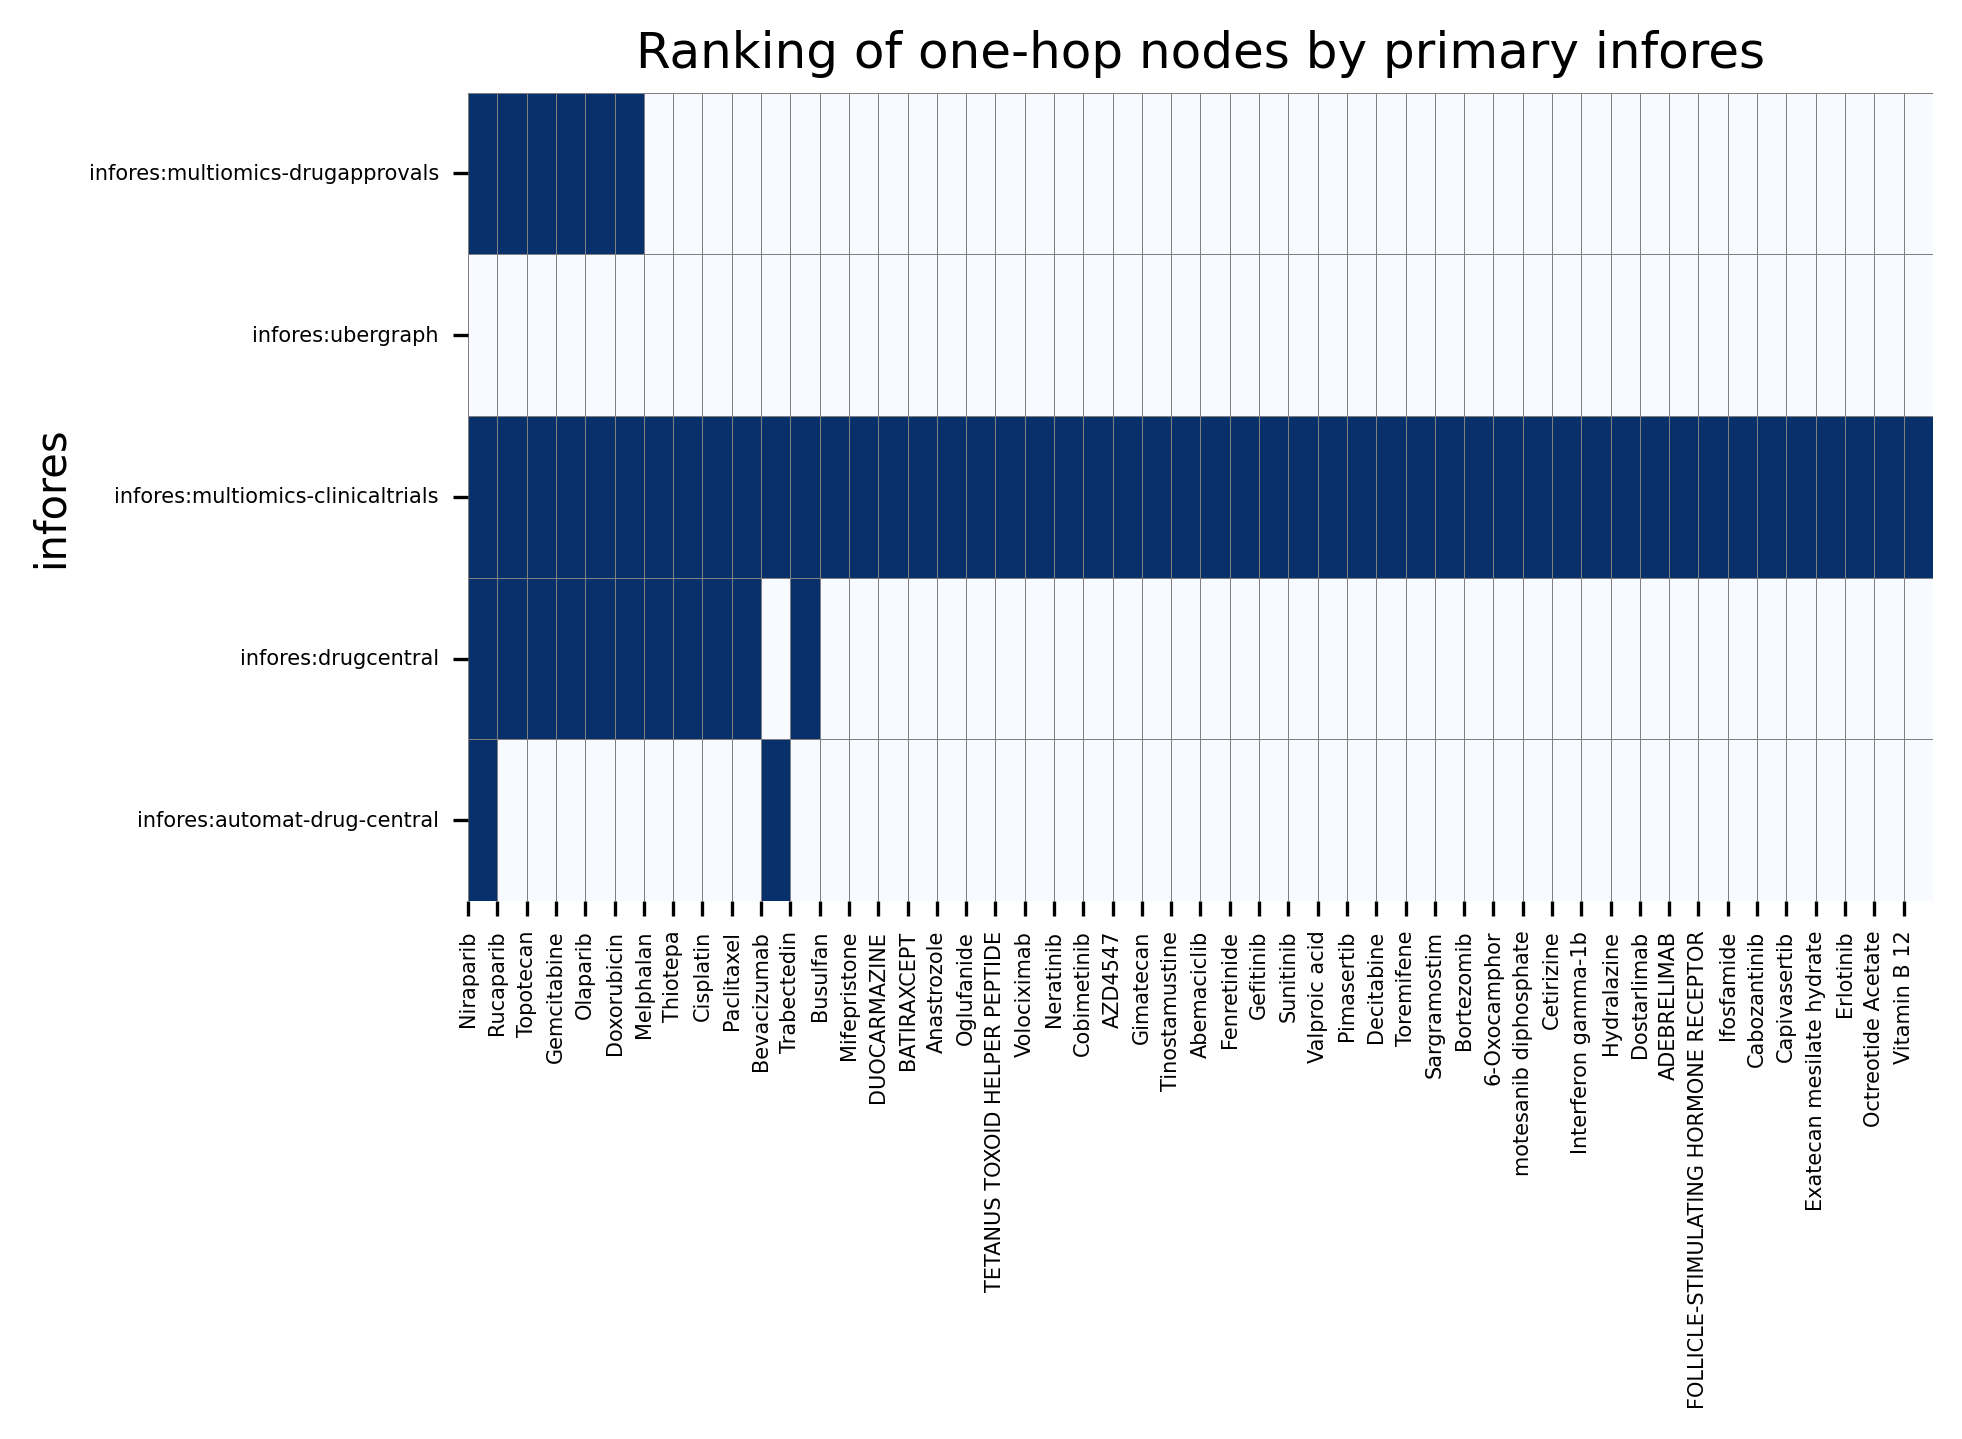

[Text(0.5, 0, 'Niraparib'), Text(2.5, 0, 'Topotecan'), Text(4.5, 0, 'Olaparib'), Text(6.5, 0, 'Melphalan'), Text(8.5, 0, 'Cisplatin'), Text(10.5, 0, 'Bevacizumab'), Text(12.5, 0, 'Busulfan'), Text(14.5, 0, 'DUOCARMAZINE'), Text(16.5, 0, 'Anastrozole'), Text(18.5, 0, 'TETANUS TOXOID HELPER PEPTIDE'), Text(20.5, 0, 'Neratinib'), Text(22.5, 0, 'AZD4547'), Text(24.5, 0, 'Tinostamustine'), Text(26.5, 0, 'Fenretinide'), Text(28.5, 0, 'Sunitinib'), Text(30.5, 0, 'Pimasertib'), Text(32.5, 0, 'Toremifene'), Text(34.5, 0, 'Bortezomib'), Text(36.5, 0, 'motesanib diphosphate'), Text(38.5, 0, 'Interferon gamma-1b'), Text(40.5, 0, 'Dostarlimab'), Text(42.5, 0, 'FOLLICLE-STIMULATING HORMONE RECEPTOR'), Text(44.5, 0, 'Cabozantinib'), Text(46.5, 0, 'Exatecan mesilate hydrate'), Text(48.5, 0, 'Octreotide Acetate')]


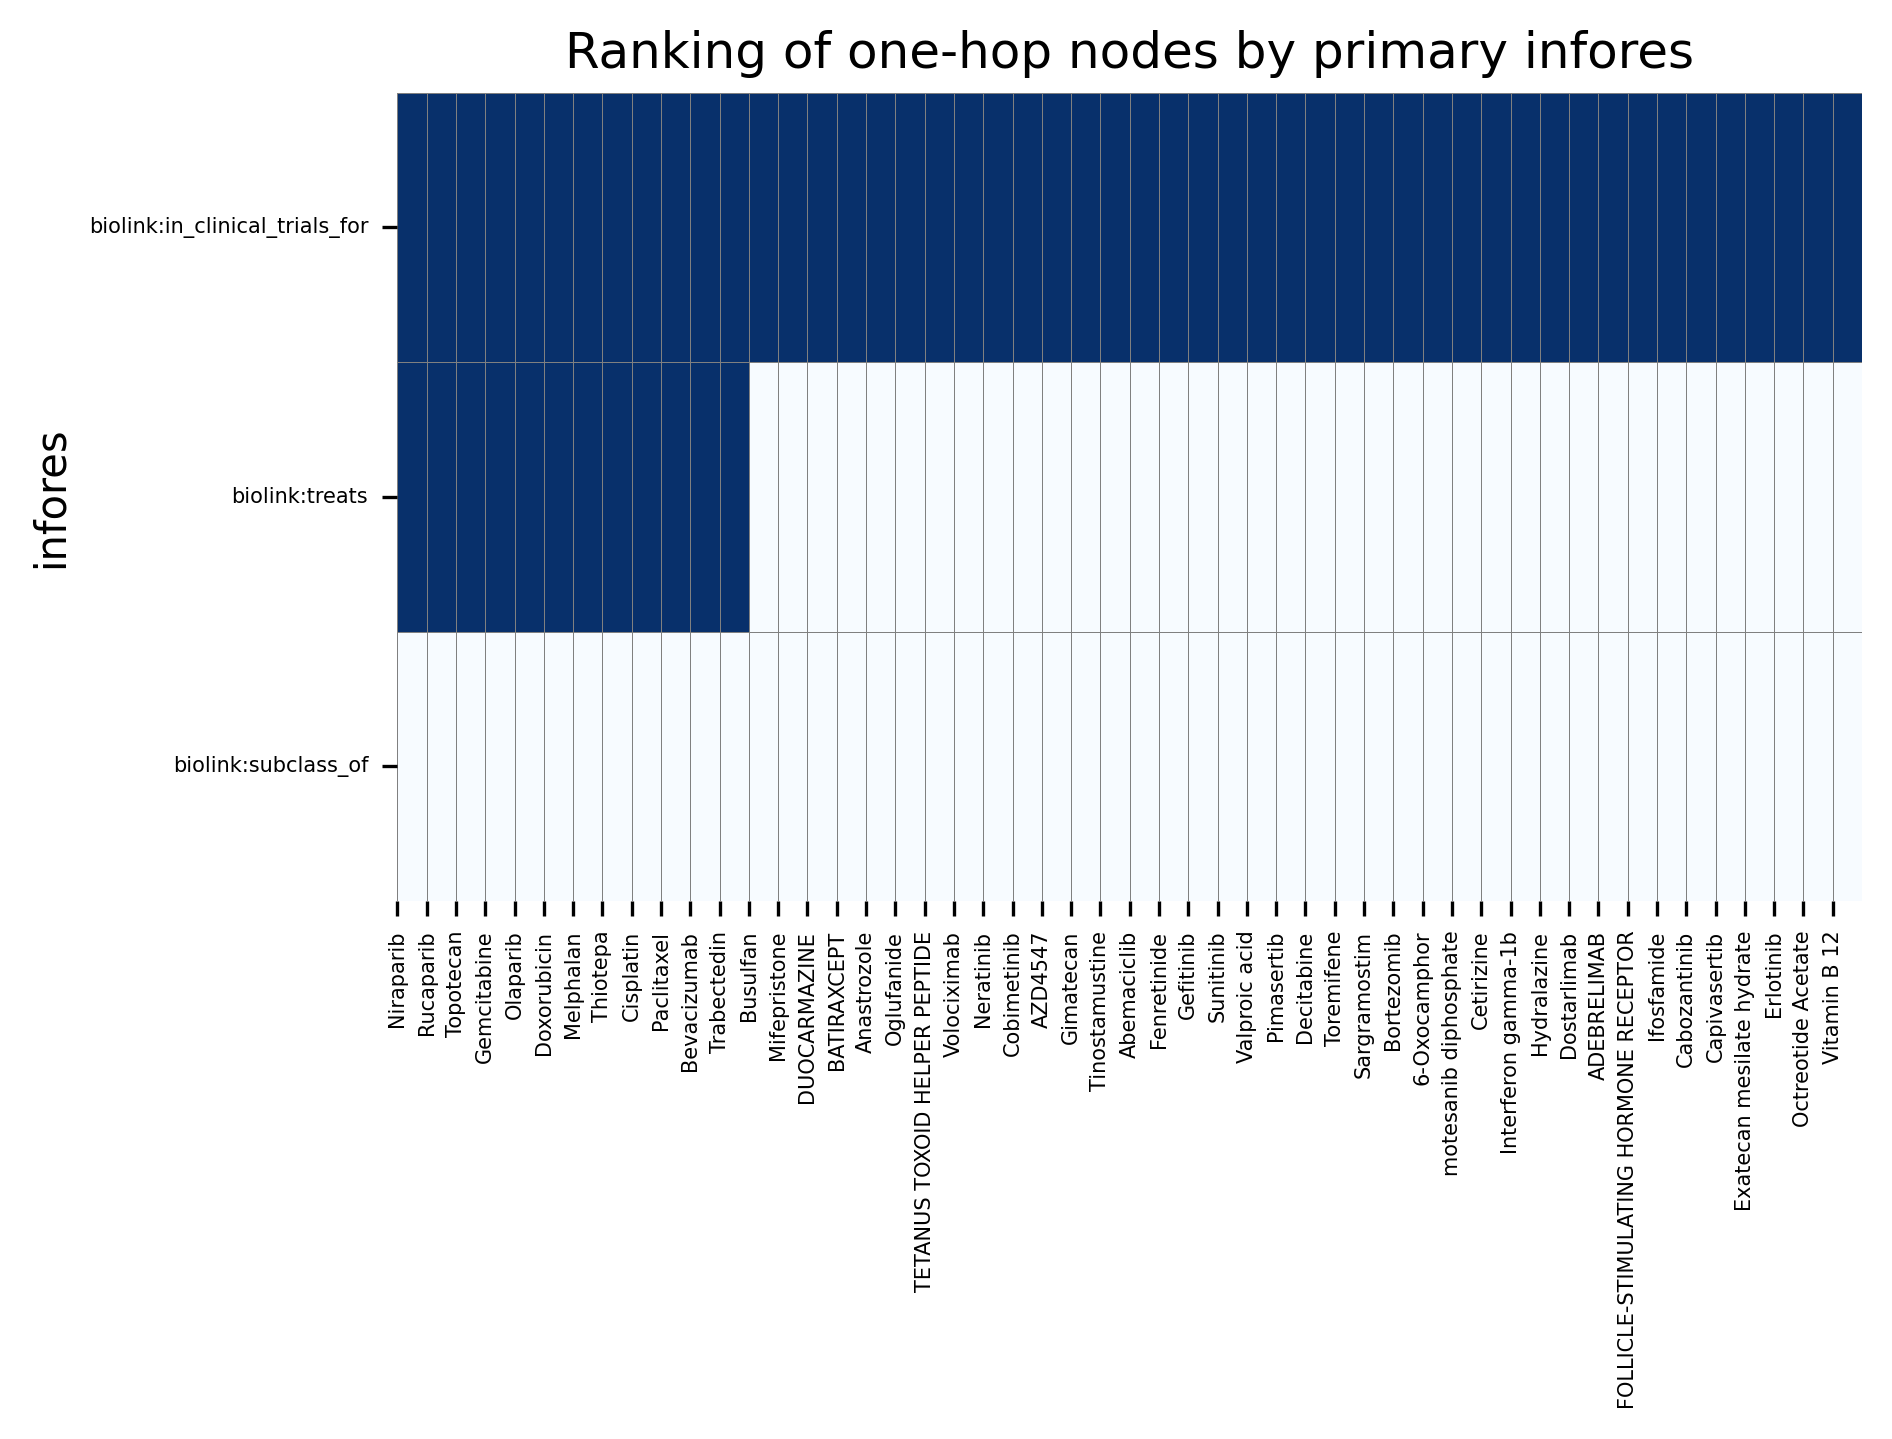

,Niraparib,Rucaparib,Topotecan,Gemcitabine,Olaparib,Doxorubicin,Melphalan,Thiotepa,Cisplatin,Paclitaxel,...,EFBEMALENOGRASTIM ALFA,Thalidomide,Tanespimycin,Metformin,FIANLIMAB,PRALUZATAMAB RAVTANSINE,Cyclosporine,UNII:YR3G369F5A,CDX-301,DT-2216
biolink:in_clinical_trials_for,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
biolink:treats,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:subclass_of,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 50, input_query = input_node1_id, 
                                fontsize = 5)

In [62]:
result_ranked_by_primary_infores.head(30)

,output_node,Name,Num_of_primary_infores,type_of_nodes,unique_predicates
6,CHEBI:176844,Niraparib,4,subject,"[biolink:treats, biolink:treats, biolink:treat..."
0,CHEBI:134689,Rucaparib,3,subject,"[biolink:treats, biolink:treats, biolink:in_cl..."
1,CHEBI:63632,Topotecan,3,subject,"[biolink:treats, biolink:treats, biolink:in_cl..."
3,CHEBI:175901,Gemcitabine,3,subject,"[biolink:treats, biolink:treats, biolink:in_cl..."
4,CHEBI:83766,Olaparib,3,subject,"[biolink:treats, biolink:treats, biolink:in_cl..."
5,CHEBI:28748,Doxorubicin,3,subject,"[biolink:treats, biolink:treats, biolink:treat..."
16,CHEBI:28876,Melphalan,2,subject,"[biolink:treats, biolink:in_clinical_trials_for]"
14,CHEBI:9570,Thiotepa,2,subject,"[biolink:treats, biolink:in_clinical_trials_for]"
12,PUBCHEM.COMPOUND:5702198,Cisplatin,2,subject,"[biolink:treats, biolink:in_clinical_trials_for]"
11,CHEBI:45863,Paclitaxel,2,subject,"[biolink:treats, biolink:in_clinical_trials_for]"


In [45]:
# End of the example
